## Image based simulations

## Import necessary packages

In [2]:
import os
import warnings
import h5py
import numpy as np
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

## Generate image from porespy: create a 3D image using PoreSpy’s poly_disperese_spheres generator

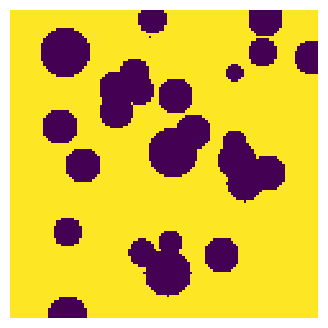

In [3]:
np.random.seed(17)
shape = [120, 120, 50]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Computing the tortuosity

In [4]:
results = ps.simulations.tortuosity_fd(im=im, axis=1)
print(results)

[01:20:09] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=611698;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=596512;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py#74\74]8;;\

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Sat Oct 26 01:20:18 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (120, 120, 50)
tortuosity                1.31364136784996
formation_factor          1.8945232450363976
original_porosity         0.6934138888888889
effective_porosity        0.6933888888888889
concentration             Array of size (120, 120, 50)
sys                       (<499240x499240 sparse matrix of type '<class 'numpy.float64'>'
	with 3303896 stored elements in COOrdinate format>, array([5.73753305, 5.73753305, 5.73753305, ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## Extract the network using snow2 algorithm

In [5]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization=None)
regions = snow.regions
net = snow.network

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/101 [00:00<?, ?it/s]

### Computing the diffusive size factor and assigning it to the network

In [6]:
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor_AI'] = g_FD

Preparing images and DNS calculations:   0%|          | 0/342 [00:00<?, ?it/s]

### These are the code for plotting 3D relative permeability and relative diffusivity of simulations

In [5]:
import os

def plot_relative_permeability(results, network, im, save_dir):
    # Create the specified directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Define style elements
    line_styles = {'x': 'solid', 'y': 'dashed', 'z': 'dotted'}
    line_width = 1.5
    marker_styles = {'x': 'o', 'y': 's', 'z': '^'}
    
    for direction in results['saturation'].keys():
        # Smooth the data
        saturation = results['saturation'][direction]
        kr_air = results['kr_air'][direction]
        kr_water = results['kr_water'][direction]

        # Interpolation
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)

        # Plotting both air and water with different styles for each direction
        ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)
        ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(save_dir, "relative_permeability_plot.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot saved at {plot_path}")

    # Network Visualization
    # Microstructure visualization
    fig, ax = plt.subplots(1, 1, figsize=[4, 4], dpi=300)
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)
    microstructure_path = os.path.join(save_dir, "microstructure.png")
    plt.savefig(microstructure_path, format='png')
    plt.close(fig)
    print(f"Microstructure image saved at {microstructure_path}")

    # Network connectivity visualization
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    ax = op.visualization.plot_connections(network, ax=ax)
    ax = op.visualization.plot_coordinates(network, ax=ax)
    network_plot_path = os.path.join(save_dir, "network_plot.png")
    plt.savefig(network_plot_path, format='png')
    plt.close(fig)
    print(f"Network plot saved at {network_plot_path}")

    # Save network information
    network_info_path = os.path.join(save_dir, "network_info.txt")
    with open(network_info_path, 'w') as f:
        f.write(str(network))
    print(f"Network information saved at {network_info_path}")
    
    salome_file = save_dir + 'network_to_salome'
    ## Export to Salome
    op.io.network_to_salome(pn,filename=str(salome_file))

    # Save the network to salome
    
def plot_relative_diffusivity(results, save_dir):
    # Create the specified directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Define style elements
    line_styles = {'x': 'solid', 'y': 'dashed', 'z': 'dotted'}
    line_width = 1.5
    marker_styles = {'x': 'o', 'y': 's', 'z': '^'}
    
    for direction in results['saturation'].keys():
        # Smooth the data
        saturation = results['saturation'][direction]
        Dr_air = results['Dr_air'][direction]
        Dr_water = results['Dr_water'][direction]

        # Interpolation
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation,Dr_water, kind='linear')
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)

        # Plotting both air and water with different styles for each direction
        ax.plot(smooth_saturation, smooth_Dr_air, label=f'Dr_air ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)
        ax.plot(smooth_saturation, smooth_Dr_water, label=f'Dr_water ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Diffusivity (Dr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Diffusivity in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(save_dir, "relative_diffusivity_plot.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative diffusivity plot saved at {plot_path}")
    plt.show()




## Simulation from artificial generated image
From the generated images, the pores connectivity and coordinates were extracted , and used to rebuild the network for simulations with openPNM

### Compute relative permeability

In [7]:
print(help(ps.generators.polydisperse_spheres))

Help on function polydisperse_spheres in module porespy.generators._imgen:

polydisperse_spheres(shape, porosity: float, dist, nbins: int = 5, r_min: int = 5, seed=None)
    Create an image of randomly placed, overlapping spheres with a
    distribution of radii.

    Parameters
    ----------
    shape : list
        The size of the image to generate in [Nx, Ny, Nz] where Ni is the
        number of voxels in each direction.  If shape is only 2D, then an
        image of polydisperse disks is returns
    porosity : float
        The porosity of the image, defined as the number of void voxels
        divided by the number of voxels in the image. The specified value
        is only matched approximately, so it's suggested to check this
        value after the image is generated.
    dist : scipy.stats distribution object
        This should be an initialized distribution chosen from the large
        number of options in the ``scipy.stats`` submodule.  For instance,
        a normal dis

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1376 [00:00<?, ?it/s]


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x22c0b366d50>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  4368 / 4368
  3  pore.coords                                                   1376 / 1376
  4  pore.region_label                                             1376 / 1376
  5  pore.phase                                                    1376 / 1376
  6  throat.phases                                                 4368 / 4368
  7  pore.region_volume                                            1376 / 1376
  8  pore.equivalent_diameter                                      1376 / 1376
  9  pore.local_peak                                               1376 / 1376
 1

[17:12:46] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=79614;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=540919;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[17:12:53] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=105096;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=923533;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=633237;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=339350;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

NameError: name 'plot_relative_permeability' is not defined

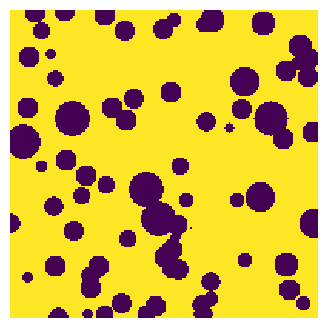

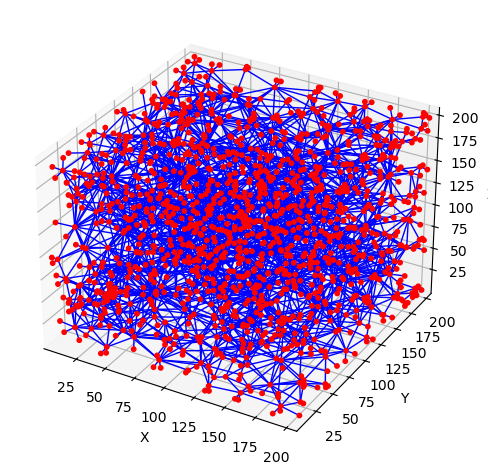

In [4]:
#pn['throat.volume'] = pn['throat.cross_sectional_area']*pn['throat.total_length']
import os
import warnings
import h5py
import numpy as np
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Generate microstructure
np.random.seed(17)
shape = [200, 200, 200]
dist = sp.stats.norm(loc=7, scale=5)

im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)


fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Extract the nework using snow algorithm
voxel_size =1
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD

"""
## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor_AI'] = g_FD
"""
#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']

pn.regenerate_models()
print(pn)

pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  
#pn['throat.diffusive_size_factor'] = g_FD
pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)

"""
## Creating network using pore coordinates and  connectivity 
coords = pn1['pore.coords']
conns = pn1['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
""" 

print(pn)
ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)


#pn.regenerate_models()
pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)
print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
""" 
Ps = pn['pore.cluster_size'] < 100
op.topotools.trim(network=pn, pores=Ps)
ax = op.visualization.plot_tutorial(pn, font_size=8)
"""
###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('zmin')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

flow_in = pn.pores('zmin')
flow_out = pn.pores('zmax')

model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores(inlet)
    Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
    ip.set_inlet_BC(pores=Finlets)
    ip.run()
    max_seq = np.max([np.max(ip['pore.invasion_sequence']),
            np.max(ip['throat.invasion_sequence'])])
    start = max_seq//Snwp_num
    stop = max_seq
    step = max_seq//Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models();
        water.regenerate_models();
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
        relperm_wp.append(Rate_ewp/Rate_abs_wp)
        
               # Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['kr_air'][direction] = np.array(relperm_nwp).flatten()
        results['kr_water'][direction] = np.array(relperm_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        kr_air = np.array(relperm_nwp).flatten()
        kr_water = np.array(relperm_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)
        
# Call the plot function
save_dir= 'rock_sample_leopard'
plot_relative_permeability(results,pn, im, save_dir)

In [6]:
# Call the plot function
save_dir= 'artificial_image'
plot_relative_permeability(results,pn, im, save_dir)

Relative permeability plot saved at artificial_image\relative_permeability_plot.png
Microstructure image saved at artificial_image\microstructure.png
Network plot saved at artificial_image\network_plot.png
Network information saved at artificial_image\network_info.txt


0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1376 [00:00<?, ?it/s]


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x1fb9845de50>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  4368 / 4368
  3  pore.coords                                                   1376 / 1376
  4  pore.region_label                                             1376 / 1376
  5  pore.phase                                                    1376 / 1376
  6  throat.phases                                                 4368 / 4368
  7  pore.region_volume                                            1376 / 1376
  8  pore.equivalent_diameter                                      1376 / 1376
  9  pore.local_peak                                               1376 / 1376
 1

[02:17:35] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=671396;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=404782;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

NameError: name 'plot_relative_diffusivity' is not defined

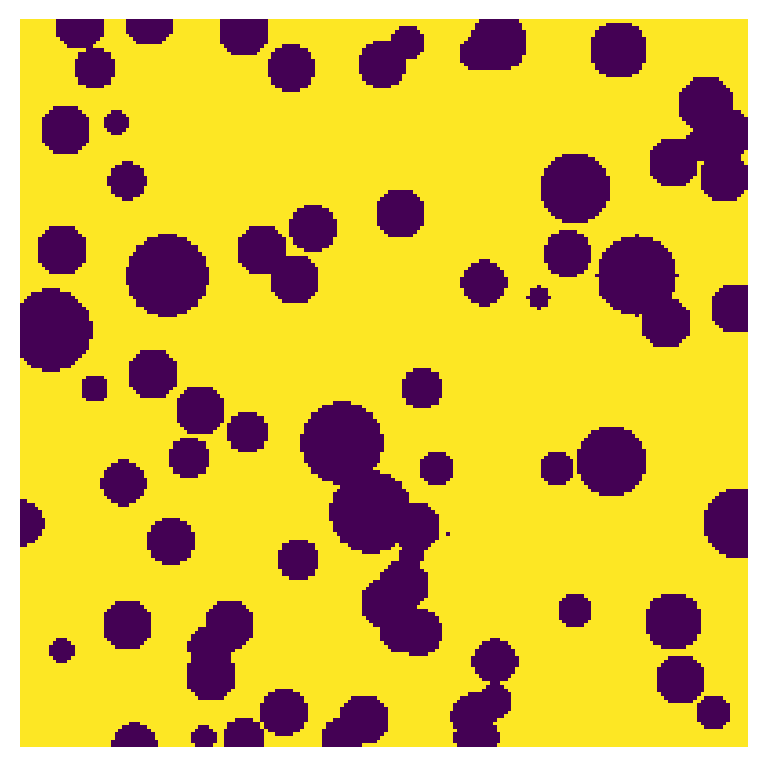

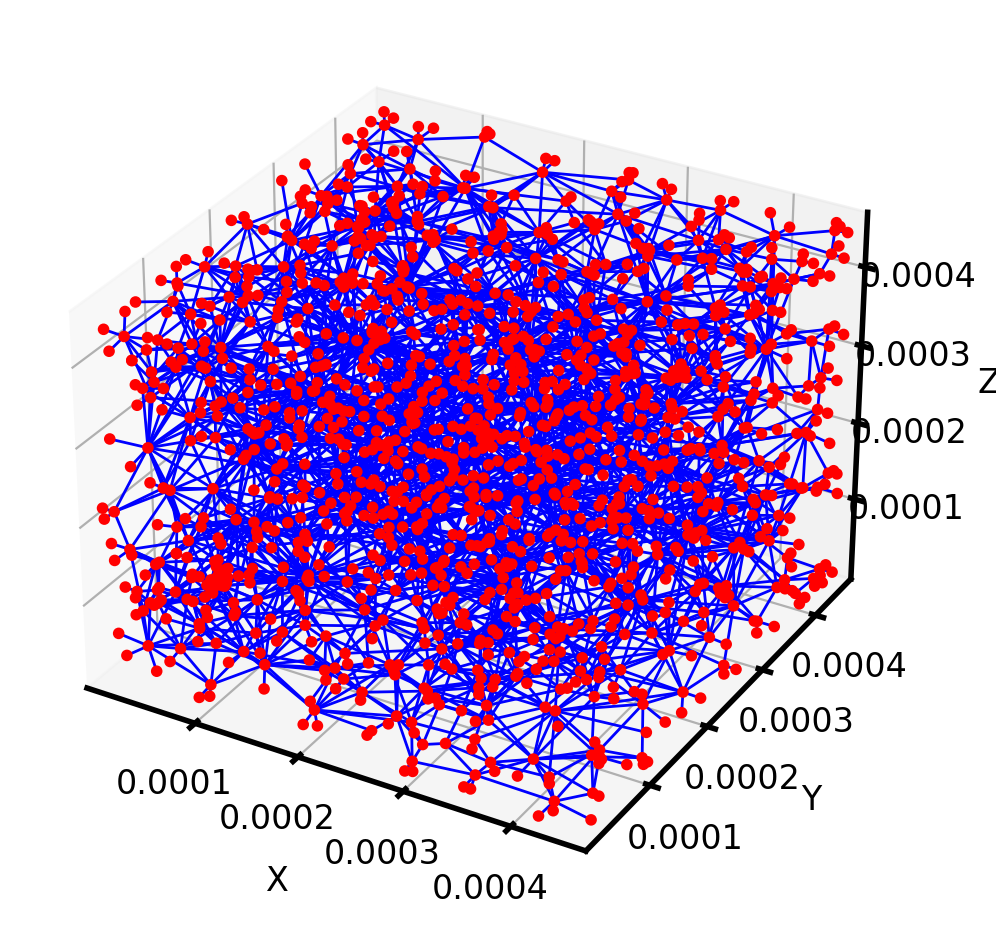

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Generate microstructure

np.random.seed(17)
shape = [200, 200, 200]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Extract the nework using snow algorithm

### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network


## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor_AI'] = g_FD

"""
#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']
pn.regenerate_models()
print(pn)


pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  

pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)


ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

#pn.regenerate_models()

pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)

print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
""" 
Ps = pn['pore.cluster_size'] < 1290
op.topotools.trim(network=pn, pores=Ps)
#ax = op.visualization.plot_tutorial(pn, font_size=8)
"""
###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

def sat_update_diffusivity(network, nwp, wp):
    r"""
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
    """
    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

def Rate_calc_diffusivity(network, phase, inlet, outlet, conductance):
        phase.regenerate_models()
        Fd = op.algorithms.FickianDiffusion(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val
    
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')

Snwp_num=400

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'Dr_air': {}, 'Dr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    ## Drainage simulations
    drn = op.algorithms.Drainage(network=pn, phase=water)
    drn.set_inlet_BC(pn.pores(inlet))
    drn.run()

    water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
        
    diff_in = pn.pores(inlet)
    diff_out = pn.pores(outlet)
    ## Calculate the relative diffusivity
    Snwparr = []
    reldiff_nwp = []
    reldiff_wp = []
    for Pc in np.unique(drn['pore.invasion_pressure']):
        water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
        water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
        air['pore.occupancy'] = 1 - water['pore.occupancy']
        air['throat.occupancy'] = 1 - water['throat.occupancy']
        air.regenerate_models()
        water.regenerate_models()
        sat_point = sat_update_diffusivity(pn, water, air)
        Snwparr.append(sat_point)
        Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
        reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
        
        #Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['Dr_air'][direction] = np.array(reldiff_nwp).flatten()
        results['Dr_water'][direction] = np.array(reldiff_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        Dr_air = np.array(reldiff_nwp).flatten()
        Dr_water = np.array(reldiff_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation, Dr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 200)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)



In [6]:
save_dir ='artificial_image'
plot_relative_diffusivity(results, save_dir)

Relative diffusivity plot saved at artificial_image\relative_diffusivity_plot.png


## Simulation from experimental acquired image stored in Digital Rock portal

In [1]:
import os
import numpy as np

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

def load_image_to_3d(filename, data_type, voxelsx=None, voxelsy=None):
    """
    Loads a raw image from the specified path or URL, reshapes it into 3D based on inferred dimensions.
    Assumes a cubic image by default if no dimensions are provided.

    Parameters:
    path (str): Directory where the image will be saved.
    name (str): Name of the image file.
    url (str): URL to download the image if not already present.
    data_type (str): Data type for reading the image file (e.g., '<i1' for 1-byte signed integer).
    voxel_size (float): The size of each voxel in meters.
    voxelsx (int, optional): Known voxel count along the x-dimension. If not provided, assumes cubic.
    voxelsy (int, optional): Known voxel count along the y-dimension. If not provided, assumes cubic.

    Returns:
    im (numpy.ndarray): The reshaped 3D image.
    (voxelsx, voxelsy, voxelsz) (tuple of int): The inferred voxel dimensions.
    """
    # Ensure the directory exists

    # Load the raw image data
    image_data = np.fromfile(filename, dtype=data_type)
    
    # Total number of voxels
    total_voxels = image_data.size
    
    # If no dimensions are provided, assume the image is cubic
    if voxelsx is None and voxelsy is None:
        # Assuming a cubic image, calculate the side length
        voxelsx = int(round(total_voxels ** (1/3)))
        voxelsy = voxelsx
        voxelsz = voxelsx
    elif voxelsx is not None and voxelsy is not None:
        # If both voxelsx and voxelsy are provided, infer voxelsz
        voxelsz = total_voxels // (voxelsx * voxelsy)
        
        if total_voxels != voxelsx * voxelsy * voxelsz:
            raise ValueError("The inferred dimensions do not match the total number of voxels.")
    elif voxelsx is not None and voxelsy is None:
        # If only voxelsx is provided, assume a cubic y-dimension and infer z-dimension
        voxelsy = voxelsx
        voxelsz = total_voxels // (voxelsx * voxelsy)
        
        if total_voxels != voxelsx * voxelsy * voxelsz:
            raise ValueError("The inferred dimensions do not match the total number of voxels.")
    else:
        raise ValueError("You must provide at least one dimension (voxelsx) to infer the others if the image is not cubic.")
    
    # Reshape the image into the inferred 3D dimensions
    im = np.reshape(image_data, (voxelsx, voxelsy, voxelsz))
    
    # Return the reshaped image and its dimensions
    return im, (voxelsx, voxelsy, voxelsz)


In [3]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")


## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'rock_sample_Leopard'
name = 'image_Leopard.raw'
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

data_type = '<i1'  # 1-byte signed integer
voxel_size = 2.25e-6  # Voxel size in meters

# Assume cubic image
filename= path + '/' + name
download_image(filename, url)
image, dimensions = load_image_to_3d(filename, url, data_type, voxel_size)

print(f"Reshaped 3D image has dimensions: {dimensions}")

### Identify pore space and solid space
# pore space must be labeled as True and solid phase as False
pore_space = im == 0 # sometimes this may be 255 or some other value depending on the source of the image
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))

im = im[:400,:400,:400]

### Reduce the size of the image to be more manageable
""" 
coords = net_drp ['pore.coords']
conns = net_drp['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)

"""
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network

## uncomment to Compute diffusive size factor if needed and assign it to the network

""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD
"""

#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.cubes_and_cuboids
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']
pn.regenerate_models()
print(pn)

pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)

pn.regenerate_models()
## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)


ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

#pn.regenerate_models()

pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)

print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Ps = pn['pore.cluster_size'] < 1290
op.topotools.trim(network=pn, pores=Ps)
#ax = op.visualization.plot_tutorial(pn, font_size=8)

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()


def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores(inlet)
    Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
    ip.set_inlet_BC(pores=Finlets)
    ip.run()
    max_seq = np.max([np.max(ip['pore.invasion_sequence']),
            np.max(ip['throat.invasion_sequence'])])
    start = max_seq//Snwp_num
    stop = max_seq
    step = max_seq//Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models();
        water.regenerate_models();
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
        relperm_wp.append(Rate_ewp/Rate_abs_wp)
        
               # Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['kr_air'][direction] = np.array(relperm_nwp).flatten()
        results['kr_water'][direction] = np.array(relperm_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        kr_air = np.array(relperm_nwp).flatten()
        kr_water = np.array(relperm_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)


InterruptedError: wget was not found. Please make sure it is installed on your system.

In [40]:
# Call the plot function
save_dir= 'rock_sample_leopard'
plot_relative_permeability(results,pn, im, save_dir)

Relative permeability plot saved at rock_sample_leopard/relative_permeability_plot.png
Microstructure image saved at rock_sample_leopard/microstructure.png
Network plot saved at rock_sample_leopard/network_plot.png
Network information saved at rock_sample_leopard/network_info.txt


In [ ]:

## Drainage simulations
drn = op.algorithms.Drainage(network=pn, phase=water)
drn.set_inlet_BC(pn.pores('left'))
drn.run()

water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
air['pore.occupancy'] = 1 - water['pore.occupancy']
air['throat.occupancy'] = 1 - water['throat.occupancy']


diff_in = pn.pores('left')
diff_out = pn.pores('right')

## Define multiphase conductance
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

## Calculate the relative diffusivity
Snwparr = []
reldiff_nwp = []
reldiff_wp = []
for Pc in np.unique(drn['pore.invasion_pressure']):
    water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    air.regenerate_models()
    water.regenerate_models()
    sat_point = sat_update_diffusivity(pn, water, air)
    Snwparr.append(sat_point)
    Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
    reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
    
## Calculate the relative permeability
plt.figure(figsize=[6,5])
plt.plot(Snwparr, reldiff_nwp, '*-', label='Dr_nwp')
plt.plot(Snwparr, reldiff_wp, 'o-', label='Dr_wp')
plt.xlabel('Snwp')
plt.ylabel('Dr')
plt.title('Relative Diffusivity in x direction')
plt.legend()

Reshaped 3D image has dimensions: (1000, 1000, 1000)
0.353452


0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1718 [00:00<?, ?it/s]


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x2af44eed0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  2034 / 2034
  3  pore.coords                                                   1718 / 1718
  4  pore.region_label                                             1718 / 1718
  5  pore.phase                                                    1718 / 1718
  6  throat.phases                                                 2034 / 2034
  7  pore.region_volume                                            1718 / 1718
  8  pore.equivalent_diameter                                      1718 / 1718
  9  pore.local_peak                                               1718 / 1718
 10 

[18:17:35] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=625969;file:///Users/justinkinda/Dropbox/ResarchcColab/Tulio_Farid/OpenPNM/openpnm/core/_models.py\_models.py]8;;\:]8;id=684225;file:///Users/justinkinda/Dropbox/ResarchcColab/Tulio_Farid/OpenPNM/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

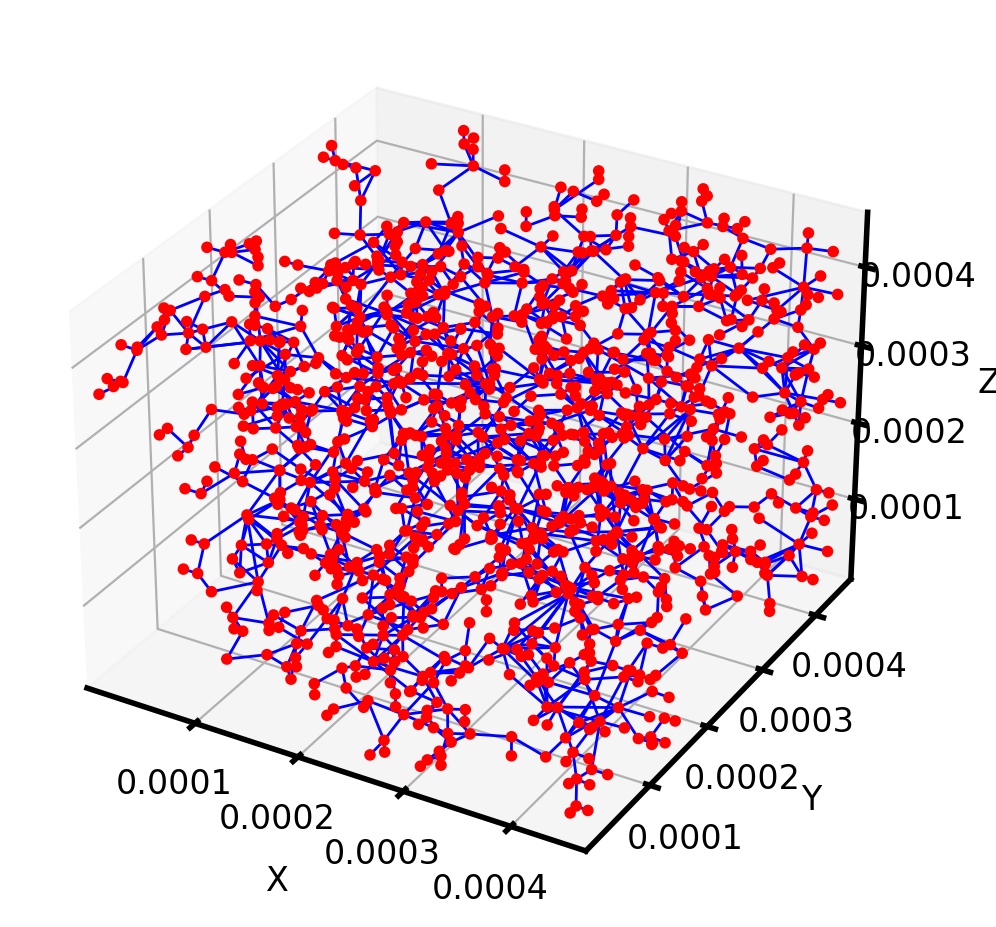

In [43]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")


## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'rock_sample_Leopard'
name = 'image_Leopard.raw'
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

data_type = '<i1'  # 1-byte signed integer
voxel_size = 2.25e-6  # Voxel size in meters

# Assume cubic image
image, dimensions = load_image_to_3d(path, name, url, data_type, voxel_size)

print(f"Reshaped 3D image has dimensions: {dimensions}")

### Identify pore space and solid space
# pore space must be labeled as True and solid phase as False
pore_space = im == 0 # sometimes this may be 255 or some other value depending on the source of the image
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))

im = im[:400,:400,:400]


### Reduce the size of the image to be more manageable

""" 
coords = net_drp ['pore.coords']
conns = net_drp['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)


from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)

"""
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network

## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD
"""
#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.cubes_and_cuboids
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']
pn.regenerate_models()
print(pn)


pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  

pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)


## Export to Salome
op.io.network_to_salome(pn,filename='salome/image_Leopard')

ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

#pn.regenerate_models()

pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)

print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Ps = pn['pore.cluster_size'] < 1290
op.topotools.trim(network=pn, pores=Ps)
#ax = op.visualization.plot_tutorial(pn, font_size=8)

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

def sat_update_diffusivity(network, nwp, wp):
    r"""
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
    """
    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

def Rate_calc_diffusivity(network, phase, inlet, outlet, conductance):
        phase.regenerate_models()
        Fd = op.algorithms.FickianDiffusion(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val
    
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'Dr_air': {}, 'Dr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    ## Drainage simulations
    drn = op.algorithms.Drainage(network=pn, phase=water)
    drn.set_inlet_BC(pn.pores(inlet))
    drn.run()

    water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
        
    diff_in = pn.pores(inlet)
    diff_out = pn.pores(outlet)
    ## Calculate the relative diffusivity
    Snwparr = []
    reldiff_nwp = []
    reldiff_wp = []
    for Pc in np.unique(drn['pore.invasion_pressure']):
        water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
        water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
        air['pore.occupancy'] = 1 - water['pore.occupancy']
        air['throat.occupancy'] = 1 - water['throat.occupancy']
        air.regenerate_models()
        water.regenerate_models()
        sat_point = sat_update_diffusivity(pn, water, air)
        Snwparr.append(sat_point)
        Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
        reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
        
        #Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['Dr_air'][direction] = np.array(reldiff_nwp).flatten()
        results['Dr_water'][direction] = np.array(reldiff_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        Dr_air = np.array(reldiff_nwp).flatten()
        Dr_water = np.array(reldiff_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation, Dr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)


In [45]:
 plot_relative_diffusivity(results, save_dir)

Relative permeability plot saved at rock_sample_leopard/relative_diffusivity_plot.png


# Berea sandstone

In [ ]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'data/Berea_sandstone'
name = 'Berea_2d25um_binary.raw'
data_type = '<i1'
filename = path +'/' + name
# Ensure the directory exists
voxelsx = 1000
voxelsz =1000 #Load the raw image data
voxelsy = 1000

image_data = np.fromfile(filename, dtype=data_type)
# Total number of voxels
total_voxels = image_data.size

# Reshape the image into the inferred 3D dimensions
im = np.reshape(image_data, (voxelsx, voxelsy, voxelsz))

# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(im[:, :, 100]);
ax[1].imshow(ps.visualization.show_3D(im));
ax[2].imshow(ps.visualization.sem(im));
ax[0].set_title("Slice No. 100 View");
ax[1].set_title("3D Sketch");
ax[2].set_title("SEM View");
